In [801]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras import layers, models
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers.legacy import Adagrad, SGD, Adam
import cv2
import visualkeras
from PIL import ImageFont

In [626]:
def open_data(path):

    # Path to the folder where HDF5 files are saved
    input_folder = path#

    # Initialize an empty list to store image data
    image_data_list = []
    cloud_map_data_list = []

    # Iterate over files in the folder
    for filename in os.listdir(input_folder):
        # Check if the file is an HDF5 file
        if filename.endswith(".h5"):
            input_path = os.path.join(input_folder, filename)

            with h5py.File(input_path, 'r') as file:
                # Check if 'image' dataset exists in the file
                if 'image' in file:
                    img_data = file['image'][:]
                    cp_data = file['label_map'][:]

                    img_max_val = np.max((np.abs(img_data)))
                    img_data = img_data/40

                    image_data_list.append(img_data)
                    cloud_map_data_list.append(cp_data)
                else:
                    print(f"Dataset 'image' not found in file: {input_path}")

    # Convert the list of image data to a numpy array
    image_data = np.array(image_data_list)
    cloud_map_data = np.array(cloud_map_data_list)

    # Display the shape of the resulting array
    print(f"Shape of the image data array: {image_data.shape}")
    print(f"Shape of the cloud map data array: {cloud_map_data.shape}")

    return image_data, cloud_map_data

def cut_images(image_data, section_size, overlap=0.5):
    cut_frames = []

    for image in image_data:
        # Calculate the number of sections along each dimension
        num_rows = (image.shape[0] - section_size) // int(section_size * (1 - overlap)) + 1
        num_cols = (image.shape[1] - section_size) // int(section_size * (1 - overlap)) + 1

        # Cut the image into sections with 50% overlap
        for i in range(num_rows):
            for j in range(num_cols):
                row_start = i * int(section_size * (1 - overlap))
                row_end = row_start + section_size
                col_start = j * int(section_size * (1 - overlap))
                col_end = col_start + section_size

                # Append the cut section to the list
                cut_frames.append(image[row_start:row_end, col_start:col_end])
    
    print(f"Shape of the new data array: {(np.array(cut_frames).shape)}")

    return np.array(cut_frames)


In [839]:
image_data, cloud_map_data = open_data('/Users/lukas/Dokumente/Uni/SSI/CNN_data/')

Shape of the image data array: (44, 512, 640, 1)
Shape of the cloud map data array: (44, 512, 640, 1)


In [242]:
# Define the downsampling factor, for example, let's downsample by a factor of 2
downsampling_factor = 2

# Assuming image_data has the shape (XX, a, b, 1)
num_frames, height, width, channels = image_data.shape

# Initialize an array to store the resized frames
resized_frames = np.zeros((num_frames, height // downsampling_factor, width // downsampling_factor, channels))
resized_masks = np.zeros((num_frames, height // downsampling_factor, width // downsampling_factor, channels))


# Resize each frame and store in the new array
for i in range(num_frames):
    resized_frames[i, :, :, 0] = cv2.resize(image_data[i, :, :, 0], 
                                            (width // downsampling_factor, height // downsampling_factor), 
                                            interpolation=cv2.INTER_AREA)
    resized_masks[i, :, :, 0] = cv2.resize(cloud_map_data[i, :, :, 0], 
                                            (width // downsampling_factor, height // downsampling_factor), 
                                            interpolation=cv2.INTER_AREA)
    resized_masks[i, :, :, 0][resized_masks[i, :, :, 0]>0] = 1


In [191]:
resized_frames.shape, resized_masks.shape

((44, 256, 320, 1), (44, 256, 320, 1))

In [829]:
section_size = 128
cut_frames = cut_images(image_data, section_size=section_size, overlap=0.5)
cut_labels = cut_images(cloud_map_data, section_size=section_size, overlap=0.5)
input_shape=(section_size, section_size, 1)

Shape of the new data array: (2772, 128, 128, 1)
Shape of the new data array: (2772, 128, 128, 1)


In [834]:
section_size = 128
cut_frames = cut_images(resized_frames, section_size=section_size)
cut_labels = cut_images(resized_masks, section_size=section_size)
input_shape=(section_size, section_size, 1)

Shape of the new data array: (528, 128, 128, 1)
Shape of the new data array: (528, 128, 128, 1)


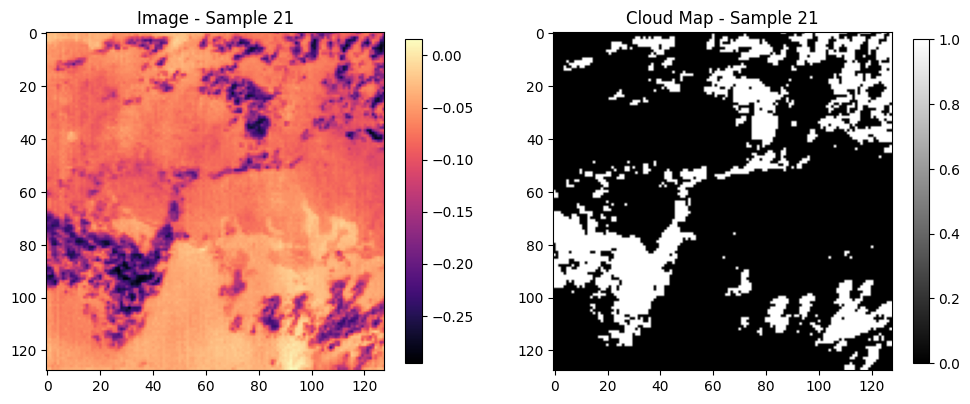

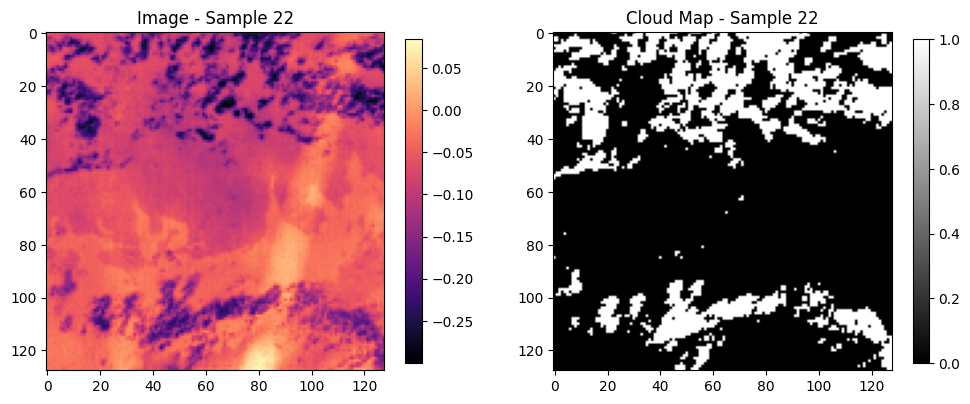

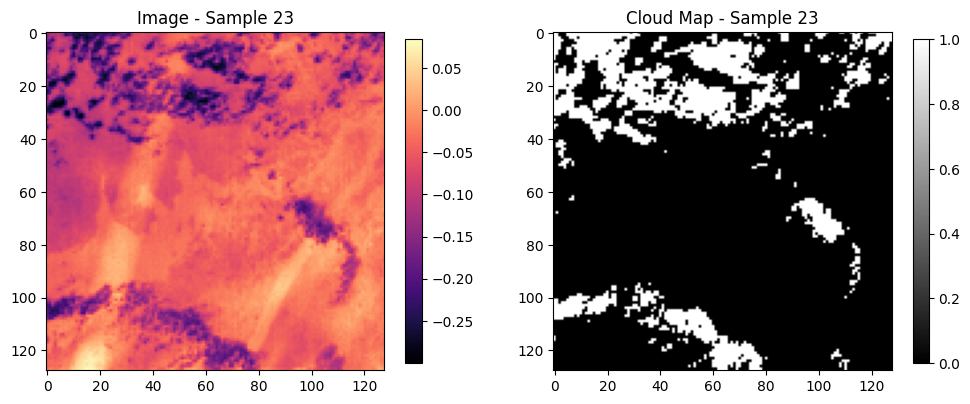

In [838]:
# Number of samples to plot
num_samples = 3
i_offset = 20

# Plot the images and their corresponding cloud maps
for i in range(num_samples):
    plt.figure(figsize=(12, 6))

    # Plot the first image
    plt.subplot(1, 2, 1)
    plt.imshow(cut_frames[i + i_offset, :, :, 0], cmap='magma')
    plt.title(f'Image - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

    # Plot the corresponding cloud map
    plt.subplot(1, 2, 2)
    plt.imshow(cut_labels[i + i_offset, :, :, 0], cmap='binary_r')
    plt.title(f'Cloud Map - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

    plt.show()

In [629]:
image_train, image_test, cloud_train, cloud_test = train_test_split(cut_frames, cut_labels, test_size=0.2, random_state=42)


In [430]:
model = models.Sequential()

# Encoder
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Output layer
model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))

#optimizer = Adam(learning_rate=0.001)
#optimizer = Adagrad(learning_rate=0.001)
optimizer = SGD(learning_rate=0.005)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_103 (B  (None, 128, 128, 64)      256       
 atchNormalization)                                              
                                                                 
 conv2d_133 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_104 (B  (None, 128, 128, 64)      256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                      

In [635]:
# Encoder
inputs = layers.Input(shape=input_shape)
conv1 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
batch1 = layers.BatchNormalization()(conv1)
conv2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch1)
batch2 = layers.BatchNormalization()(conv2)
pool1 = layers.MaxPooling2D((2, 2))(batch2)

conv3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool1)
batch3 = layers.BatchNormalization()(conv3)
conv4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
batch4 = layers.BatchNormalization()(conv4)
pool2 = layers.MaxPooling2D((2, 2))(batch4)

conv5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool2)
batch5 = layers.BatchNormalization()(conv5)
conv6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)

# Decoder
up7 = layers.UpSampling2D(size=(2, 2))(conv6)
concat7 = layers.Concatenate()([up7, conv4])
batch7 = layers.BatchNormalization()(concat7)
conv7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch7)
batch8 = layers.BatchNormalization()(conv7)
conv8 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch8)
dropout8 = layers.Dropout(0.1)(conv8)

up9 = layers.UpSampling2D(size=(2, 2))(dropout8)
concat9 = layers.Concatenate()([up9, conv2])
batch9 = layers.BatchNormalization()(concat9)
conv9 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch9)
batch10 = layers.BatchNormalization()(conv9)
conv10 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch10)
dropout10 = layers.Dropout(0.2)(conv10)

# Output layer
output = layers.Conv2D(1, (1, 1), activation='sigmoid')(dropout10)

# Create the model
model = models.Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = SGD(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_224 (Conv2D)         (None, 128, 128, 128)        1280      ['input_17[0][0]']            
                                                                                                  
 batch_normalization_179 (B  (None, 128, 128, 128)        512       ['conv2d_224[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_225 (Conv2D)         (None, 128, 128, 128)        147584    ['batch_normalization_1

In [561]:
# Encoder
inputs = layers.Input(shape=input_shape)
conv1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
batch1 = layers.BatchNormalization()(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch1)
batch2 = layers.BatchNormalization()(conv2)
pool1 = layers.MaxPooling2D((2, 2))(batch2)

conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool1)
batch3 = layers.BatchNormalization()(conv3)
conv4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
batch4 = layers.BatchNormalization()(conv4)
pool2 = layers.MaxPooling2D((2, 2))(batch4)

conv5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool2)
batch41 = layers.BatchNormalization()(conv5)
conv6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch41)
batch42 = layers.BatchNormalization()(conv6)
pool3 = layers.MaxPooling2D((2, 2))(batch42)

bottleneck5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool3)
batch5 = layers.BatchNormalization()(bottleneck5)
bottleneck6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)

# Decoder
up7 = layers.UpSampling2D(size=(2, 2))(bottleneck6)
concat7 = layers.Concatenate()([up7, conv6])
batch7 = layers.BatchNormalization()(concat7)
conv7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch7)
batch8 = layers.BatchNormalization()(conv7)
conv8 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch8)
dropout8 = layers.Dropout(0.1)(conv8)

up9 = layers.UpSampling2D(size=(2, 2))(dropout8)
concat9 = layers.Concatenate()([up9, conv4])
batch9 = layers.BatchNormalization()(concat9)
conv9 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch9)
batch10 = layers.BatchNormalization()(conv9)
conv10 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch10)
dropout10 = layers.Dropout(0.2)(conv10)

up11 = layers.UpSampling2D(size=(2, 2))(dropout10)
concat11 = layers.Concatenate()([up11, conv2])
batch11 = layers.BatchNormalization()(concat11)
conv11 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch11)
batch12 = layers.BatchNormalization()(conv11)
conv12 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch12)
dropout12 = layers.Dropout(0.2)(conv12)

# Output layer
output = layers.Conv2D(1, (1, 1), activation='sigmoid')(dropout12)

# Create the model
model = models.Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = SGD(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_187 (Conv2D)         (None, 128, 128, 64)         640       ['input_14[0][0]']            
                                                                                                  
 batch_normalization_148 (B  (None, 128, 128, 64)         256       ['conv2d_187[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_188 (Conv2D)         (None, 128, 128, 64)         36928     ['batch_normalization_1

In [779]:
datagen = ImageDataGenerator(
    rotation_range=45,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.3,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3, # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Randomly flip images vertically
    fill_mode='reflect'
)

batch_size = 10
steps_per_epoch = len(image_train) // batch_size

# Fit the data generator to the training data (assuming you have a variable named 'train_images')
datagen.fit(image_train)
gen_seed = 42

# Create a generator for both the input images and the ground truth masks
image_generator = datagen.flow(image_train, batch_size=batch_size, seed=gen_seed)
mask_generator = datagen.flow(cloud_train, batch_size=batch_size, seed=gen_seed)

# Combine the generators into one using zip
train_generator = zip(image_generator, mask_generator)

#aug_train_images = datagen.flow(image_train, cloud_train, batch_size=batch_size)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


# Define a ModelCheckpoint callback to save the model at each epoch
checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_best_only=False)


In [532]:
datagen = ImageDataGenerator(
    rotation_range=45,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.3,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3, # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Randomly flip images vertically
    fill_mode='reflect'
)

# Set the seed for reproducibility
seed = 42
np.random.seed(seed)

# Create a flow generator from the original data
flow_generator = datagen.flow(image_train, batch_size=16, seed=seed)
flow_cloud_generator = datagen.flow(cloud_train, batch_size=16, seed=seed)

# Define the number of augmented samples you want for each original sample
n_augmented_samples = 4  # You can adjust this based on your needs

# Generate augmented samples and store them in new arrays
augmented_data = np.zeros((image_train.shape[0] * n_augmented_samples, image_train.shape[1], image_train.shape[2], image_train.shape[3]))
augmented_cloud_maps = np.zeros((cloud_train.shape[0] * n_augmented_samples, cloud_train.shape[1], cloud_train.shape[2], cloud_train.shape[3]))

for i in range(image_train.shape[0]):
    # Get a single augmented sample at a time
    augmented_samples_batch = next(flow_generator)
    augmented_clouds_batch = next(flow_cloud_generator)

    # Extract a single sample from the batch
    augmented_samples = augmented_samples_batch[0]
    augmented_clouds = augmented_clouds_batch[0]

    # Assign the single augmented sample to the corresponding slices
    augmented_data[i * n_augmented_samples: (i + 1) * n_augmented_samples] = augmented_samples
    augmented_cloud_maps[i * n_augmented_samples: (i + 1) * n_augmented_samples] = augmented_clouds


In [533]:
augmented_data.shape

(560, 128, 128, 1)

In [786]:
def plot_history(history):
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    #plt.yticks(np.arange(0.8,1.01,0.01))
    #plt.ylim(0.89,1)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0)
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [636]:
history = model.fit(image_train, cloud_train, batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=(image_test, cloud_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
26/26 [==============================] - 226s 9s/step - loss: 0.4434 - accuracy: 0.8106 - val_loss: 0.4745 - val_accuracy: 0.8706
Epoch 2/20
26/26 [==============================] - 219s 9s/step - loss: 0.2426 - accuracy: 0.9098 - val_loss: 0.3856 - val_accuracy: 0.9068
Epoch 3/20
26/26 [==============================] - 219s 8s/step - loss: 0.1983 - accuracy: 0.9270 - val_loss: 0.3238 - val_accuracy: 0.9060
Epoch 4/20
26/26 [==============================] - 219s 8s/step - loss: 0.2027 - accuracy: 0.9235 - val_loss: 0.3116 - val_accuracy: 0.8636
Epoch 5/20
26/26 [==============================] - 218s 8s/step - loss: 0.2020 - accuracy: 0.9206 - val_loss: 0.2700 - val_accuracy: 0.8912
Epoch 6/20
26/26 [==============================] - 223s 9s/step - loss: 0.1953 - accuracy: 0.9253 - val_loss: 0.2781 - val_accuracy: 0.8656
Epoch 7/20
26/26 [==============================] - 502s 8s/step - loss: 0.1764 - accuracy: 0.9323 - val_loss: 0.2808 - val_accuracy: 0.8521
Epoch 8/20
26

In [790]:
history_train = model.fit(image_train, cloud_train, batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=2, validation_data=(image_test, cloud_test), callbacks=[early_stopping])

# Append the values from history to history_main
history.history['loss'].extend(history_train.history['loss'])
history.history['val_loss'].extend(history_train.history['val_loss'])
history.history['accuracy'].extend(history_train.history['accuracy'])
history.history['val_accuracy'].extend(history_train.history['val_accuracy'])

Epoch 1/2
42/42 [==============================] - 225s 5s/step - loss: 0.1161 - accuracy: 0.9542 - val_loss: 0.0954 - val_accuracy: 0.9617
Epoch 2/2
42/42 [==============================] - 215s 5s/step - loss: 0.1200 - accuracy: 0.9530 - val_loss: 0.1037 - val_accuracy: 0.9604


In [788]:
history_gen = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, validation_data=(image_test, cloud_test), callbacks=[early_stopping])

# Append the values from history to history_main
history.history['loss'].extend(history_gen.history['loss'])
history.history['val_loss'].extend(history_gen.history['val_loss'])
history.history['accuracy'].extend(history_gen.history['accuracy'])
history.history['val_accuracy'].extend(history_gen.history['val_accuracy'])

Epoch 1/5
42/42 [==============================] - 219s 5s/step - loss: 0.1407 - accuracy: 0.9102 - val_loss: 0.0919 - val_accuracy: 0.9645
Epoch 2/5
42/42 [==============================] - 215s 5s/step - loss: 0.1341 - accuracy: 0.9139 - val_loss: 0.0958 - val_accuracy: 0.9617
Epoch 3/5
42/42 [==============================] - 216s 5s/step - loss: 0.1471 - accuracy: 0.9095 - val_loss: 0.0914 - val_accuracy: 0.9644
Epoch 4/5
42/42 [==============================] - 222s 5s/step - loss: 0.1360 - accuracy: 0.9112 - val_loss: 0.0917 - val_accuracy: 0.9651
Epoch 5/5
42/42 [==============================] - 218s 5s/step - loss: 0.1468 - accuracy: 0.9062 - val_loss: 0.0937 - val_accuracy: 0.9639


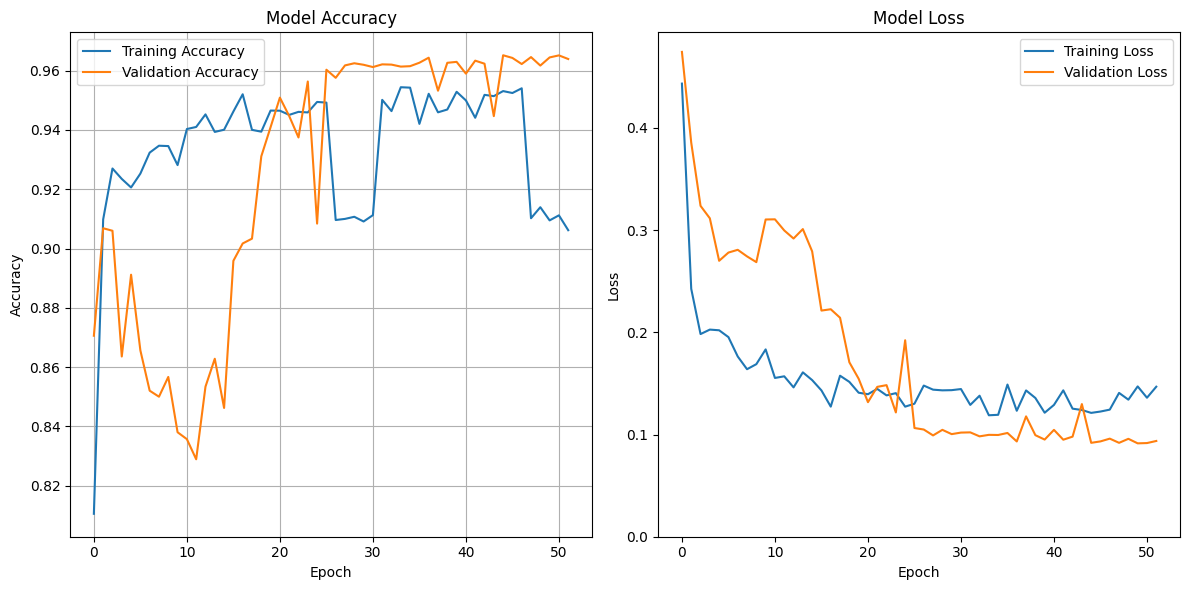

In [789]:
plot_history(history)

In [806]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_224 (Conv2D)         (None, 128, 128, 128)        1280      ['input_17[0][0]']            
                                                                                                  
 batch_normalization_179 (B  (None, 128, 128, 128)        512       ['conv2d_224[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_225 (Conv2D)         (None, 128, 128, 128)        147584    ['batch_normalization_1

In [741]:
# Predict on test data
predictions = model.predict(image_train)

prediction_threshold = 0.5

predictions[predictions < prediction_threshold] = 0
predictions[predictions >= prediction_threshold] = 1

14/14 [==============================] - 65s 5s/step


374 422


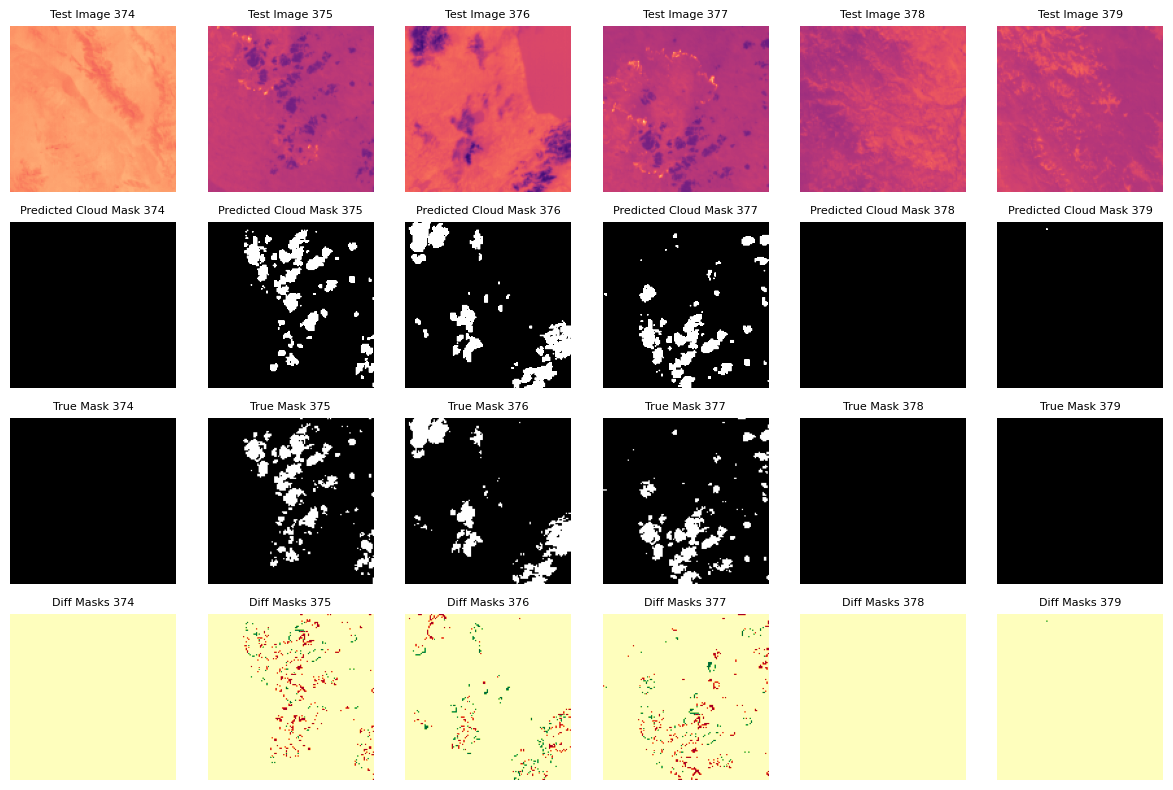

In [842]:
#label = cloud_test
#data = image_test

label = cloud_train
data = image_train

num_samples = 6

diff = np.zeros(data.shape)

rand_offset = random.randint(0, data.shape[0]-num_samples-1)
#rand_offset = 13
print(rand_offset, data.shape[0])

# Plot a few samples  # You can change this number based on your preference

plt.figure(figsize=(12, 8))

for i in range(num_samples):
    # Original image (input)
    plt.subplot(4, num_samples, i + 1)
    plt.imshow(data[i + rand_offset, :, :, 0], cmap='magma', vmin=-1, vmax=1)
    plt.title('Test Image ' + str(i + rand_offset), fontsize=8)
    plt.axis('off')

    # Predicted mask (output)
    plt.subplot(4, num_samples, i + 1 + num_samples)
    plt.imshow(predictions[i + rand_offset, :, :, 0], cmap='binary_r', vmin=0.0, vmax=0.45)
    plt.title('Predicted Cloud Mask ' + str(i + rand_offset), fontsize=8)
    plt.axis('off')

    # True mask
    plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(label[i + rand_offset, :, :, 0], cmap='binary_r', vmin=0.0, vmax=1)
    plt.title('True Mask ' + str(i + rand_offset), fontsize=8)
    plt.axis('off')



    diff[i + rand_offset, :, :, 0] = predictions[i + rand_offset, :, :, 0]-label[i + rand_offset, :, :, 0]

     # Diff mask
    plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
    plt.imshow(diff[i + rand_offset, :, :, 0], cmap='RdYlGn', vmin=-1., vmax=1.) #RdBu''
    plt.title('Diff Masks ' + str(i + rand_offset), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [778]:
model.save('best_IR_img2cpm_128_v1.keras')

In [817]:
font = ImageFont.truetype("/Users/lukas/Library/Fonts/Arial.ttf", 16)
visualkeras.layered_view(model, legend=True, font=font)

AttributeError: 'FreeTypeFont' object has no attribute 'getsize'